In [1]:
### import packages
import os
from lxml import etree
import pandas as pd
import numpy as np
import ipywidgets as w
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from scipy.interpolate import interp1d

from radstats import diagram
from radstats import environment
from radstats import models
from radstats import bayes

In [2]:
### plotly template
template = go.layout.Template()
template.layout = {
    #'margin':{'l':50,'r':50,'t':50,'b':50},
    'paper_bgcolor':'rgba(0,0,0,0)',
    'plot_bgcolor':'rgba(0,0,0,0)',
    #'xaxis':{'tickformat':'.2e'},
    'yaxis':{'tickformat':'.1e'},
    'width':950,
    'height':400,
}
pio.templates.default = template
pio.renderers.default = "vscode"

## Script settings

In [3]:
project_dir = 'projects/demo_soft'
creme_prefix = 'gto'

root = 'Payload'

orbits = 10

## Import system fault tree

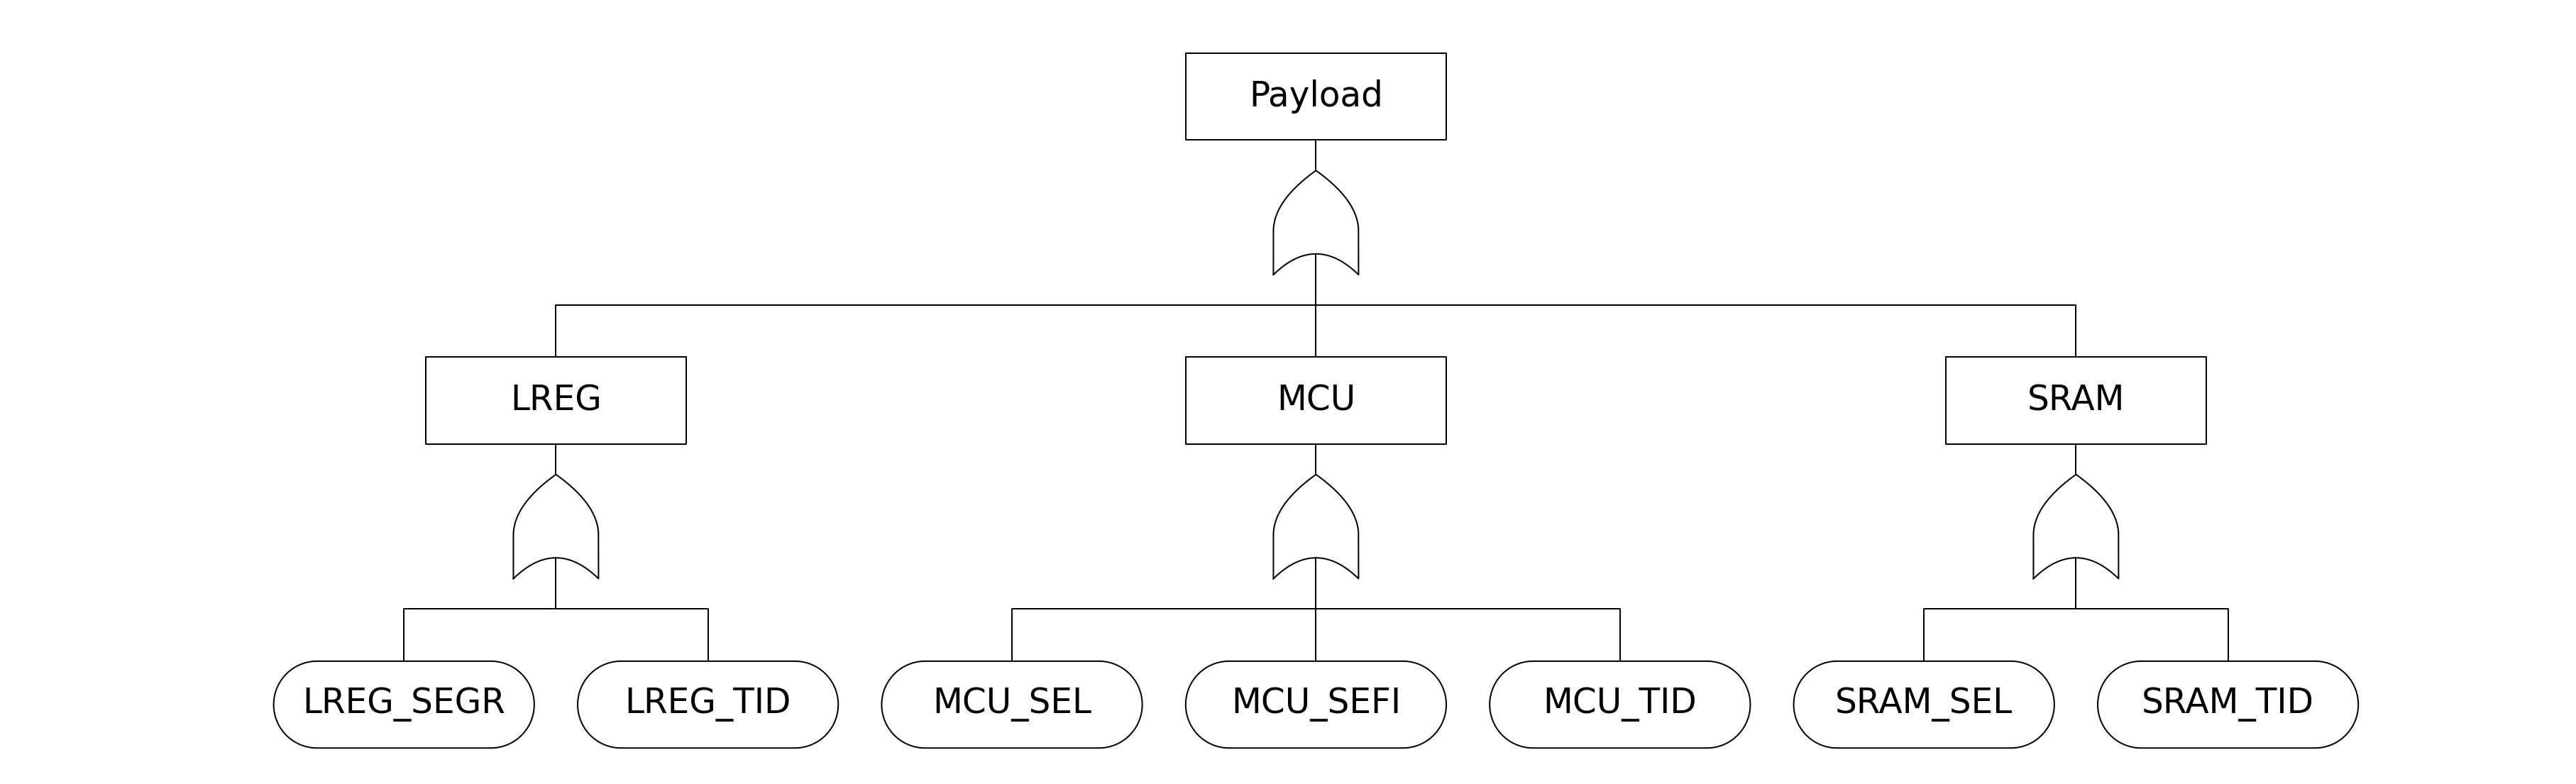

In [4]:
### read system fault tree
os.makedirs(f'{project_dir}/figures',exist_ok=True)
os.makedirs(f'{project_dir}/tables',exist_ok=True)
system = etree.parse(f'{project_dir}/system.xml')
ft = diagram.newFT(system,root,file=f'{project_dir}/figures/fault_tree.png')
ft

## Import SPENVIS trajectory

In [5]:
### read spenvis trajectory
ephem = environment.read_spenvis(f'{project_dir}/spenvis/spenvis_sao.txt')[1]['DF']
ephem['L-shell'] = environment.read_spenvis(f'{project_dir}/spenvis/spenvis_spp.txt')[1]['DF']['L (!8R!3!dE!n)']
ephem.index = pd.to_timedelta(ephem['MJD (days)']-int(ephem['MJD (days)'][0]),unit='days')
ephem.index = pd.Series(ephem.index,name='Time (hr)').dt.seconds / 3600

### repeat orbits
ephem.index = pd.Series(ephem.index).diff().bfill()
ephem.loc[:,'Orbit'] = 0
for o in range(1,orbits):
    orbit = ephem.loc[ephem['Orbit'] == 0]
    orbit.loc[:,'Orbit'] = o
    ephem = pd.concat([ephem,orbit])
ephem.index = np.around(pd.Series(ephem.index).cumsum() - ephem.index[0],5)
ephem.to_csv(f'{project_dir}/tables/ephem.csv')
display(ephem)
fig = make_subplots(specs=[[{"secondary_y": True}]])
altitude = px.line(ephem['Altitude (km)'])
mcilwain = px.line(ephem['L-shell']).update_traces(yaxis='y2')
fig.add_traces(altitude.data + mcilwain.data)
fig.update_yaxes(title='Altitude (km)')
fig.update_yaxes(title='L-shell',secondary_y=True)
fig.update_xaxes(title='Time (hr)')
fig.update_layout(showlegend=False,height=300)
fig.write_image(f'{project_dir}/figures/altitude.png',scale=3)
fig.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,MJD (days),Altitude (km),Latitude (deg),Longitude (deg),LocalTime (hrs),Alpha (deg),L-shell,Orbit
Time (hr),,,,,,,,
0.00000,26670.000000,992.8350,0.000000e+00,253.644737,16.909649,90.0,1.1655,0
0.01639,26670.000694,1002.0850,-5.631100e-07,257.865168,17.207678,90.0,1.1723,0
0.03333,26670.001389,1029.7340,-2.225477e-06,262.063303,17.504220,90.0,1.1835,0
0.04972,26670.002083,1075.4800,-4.913372e-06,266.217584,17.797839,90.0,1.1987,0
0.06667,26670.002778,1138.8350,-8.514826e-06,270.307863,18.087191,90.0,1.2182,0
...,...,...,...,...,...,...,...,...
107.74472,26670.445833,1020.0680,-3.536104e-04,85.048347,16.369890,90.0,1.1250,9
107.76167,26670.446528,997.0166,-5.375876e-04,89.255100,16.667007,90.0,1.1183,9
107.77806,26670.447222,992.4148,-7.200051e-04,93.478597,16.965240,90.0,1.1151,9


## Import CREME files

In [6]:
### read creme files

l_bins = np.around(np.geomspace(0.8*ephem['L-shell'].min(),1.2*ephem['L-shell'].max(),10),2)
l_bins = l_bins[:-1] + np.diff(l_bins) / 2
print('L bins',l_bins)
print('Trajectory min/max',[ephem['L-shell'].min(),ephem['L-shell'].max()])

effects = []
for i,l in enumerate(l_bins):
    file = open(f'{project_dir}/creme/{creme_prefix}{i+1}.hup').read()
    N = len(file.split('REPORT')) - 1
    for n in range(N): effects.append(file.split('\n')[38+12*n].split(':')[1].split('T')[0].strip())
    file = open(f'{project_dir}/creme/{creme_prefix}{i+1}.pup').read()
    N = len(file.split('REPORT')) - 1
    for n in range(N): effects.append(file.split('\n')[33+10*n].split(':')[1].split('T')[0].strip())
effects = list(set(effects))

rates = pd.DataFrame(index=pd.MultiIndex.from_product([l_bins,effects],names=['L-shell','effect']),
    columns=['dose','hup','pup'],dtype=float)

for i,l in enumerate(l_bins):
    ### get dose rate
    rates['dose'][l,] = float(open(f'{project_dir}/creme/{creme_prefix}{i+1}.dse').read().split('\n')[2].split('=')[1].split('rad')[0])
    ### get heavy ion upset rate
    file = open(f'{project_dir}/creme/{creme_prefix}{i+1}.hup').read()
    N = len(file.split('REPORT')) - 1
    for n in range(N):
        effect = file.split('\n')[38+12*n].split(':')[1].split('T')[0].strip()
        rates['hup'][l,effect] = float(file.split('\n')[48+12*n][12:32].strip())
    ### get proton upset rate
    file = open(f'{project_dir}/creme/{creme_prefix}{i+1}.pup').read()
    N = len(file.split('REPORT')) - 1
    for n in range(N):
        effect = file.split('\n')[33+10*n].split(':')[1].split('T')[0].strip()
        rates['pup'][l,effect] = float(file.split('\n')[41+10*n][12:32].strip())
    
    rates['upset'] = rates['hup'].fillna(0) + rates['pup'].fillna(0)

### get SEE probs
spline = {}
for effect in effects: spline[effect] = interp1d(l_bins,np.log(rates['upset'][:,effect]),'cubic')
spline['dose'] = interp1d(l_bins,np.log(rates['dose'][:,effect]),'cubic')
R = pd.DataFrame(index=ephem.index,columns=['dose'] + effects)
R['dose'] = np.exp(spline['dose'](ephem['L-shell']))
for effect in effects: R[effect] = np.exp(spline[effect](ephem['L-shell']))

x = np.linspace(ephem['L-shell'].min(),ephem['L-shell'].max(),1000)
splines = pd.DataFrame(index=x)
for key in spline.keys():
    splines[key] = np.exp(spline[key](x))
fig = px.line(splines,log_y=True,labels={'value':'Rate (/s)','index':'L-shell','variable':'Effect'})
fig.write_image(f'{project_dir}/figures/splines.png',scale=3)
fig.show()

### get TID probs
tid_models = {
    'SRAM_TID':[5,0.1],
    'MCU_TID':[2.5,0.15],
    'LREG_TID':[2,0.2],
    'WDOG_TID':[4,0.1],
}
P = pd.DataFrame(index=ephem.index)
tid = list((R['dose'] * pd.Series(R.index).diff().bfill().values).cumsum() * 3600 / 1000)
ephem['TID'] = tid
for key in tid_models.keys(): P[key] = models.lognormal(tid,*tid_models[key])
for effect in effects: P[effect] = 1 - np.exp(-R[effect].mul(pd.Series(R.index).diff().bfill().values).astype(float))
for effect in P.columns: R[effect] = np.absolute(-np.log(1 - P[effect]).div(pd.Series(R.index).diff().bfill().values))
effects += tid_models.keys()
parts = list(set([x.split('_')[0] for x in effects]))
print('effects',effects)
print('parts',parts)

P.to_csv(f'{project_dir}/tables/events.csv')
display(P)
fig = px.line(P,log_y=True,labels={'value':'Probability','variable':'Event'})
fig.write_image(f'{project_dir}/figures/events.png',scale=3)
fig.show()

L bins [1.015 1.3   1.66  2.12  2.71  3.46  4.42  5.65  7.22 ]
Trajectory min/max [1.1151, 6.7506]


effects ['MCU_SEL', 'MCU_SEFI', 'LREG_SEGR', 'SRAM_SEL', 'SRAM_TID', 'MCU_TID', 'LREG_TID', 'WDOG_TID']
parts ['LREG', 'WDOG', 'MCU', 'SRAM']


,SRAM_TID,MCU_TID,LREG_TID,WDOG_TID,MCU_SEL,MCU_SEFI,LREG_SEGR,SRAM_SEL
Time (hr),,,,,,,,
0.00000,0.0,0.000000,0.000000,0.0,0.000279,2.092687e-06,1.487853e-07,0.000270
0.01639,0.0,0.000000,0.000000,0.0,0.000305,2.294727e-06,1.633287e-07,0.000295
0.03333,0.0,0.000000,0.000000,0.0,0.000363,2.747458e-06,1.959047e-07,0.000352
0.04972,0.0,0.000000,0.000000,0.0,0.000423,3.215477e-06,2.298360e-07,0.000409
0.06667,0.0,0.000000,0.000000,0.0,0.000545,4.180764e-06,2.997644e-07,0.000527
...,...,...,...,...,...,...,...,...
107.74472,0.0,0.000001,0.152930,0.0,0.000157,1.153674e-06,8.148869e-08,0.000152
107.76167,0.0,0.000001,0.153099,0.0,0.000147,1.072636e-06,7.568264e-08,0.000142
107.77806,0.0,0.000001,0.153256,0.0,0.000135,9.849915e-07,6.946268e-08,0.000130


## Calculate risk over mission trajectory

In [7]:
### calculate mission risk
risk,modes,worth = bayes.risk(system,P,root)
for i,effect in enumerate(effects):
    if effect not in risk.columns: effects.pop(i)
risk.to_csv(f'{project_dir}/tables/risk.csv')
modes.to_csv(f'{project_dir}/tables/modes.csv')
worth[0].to_csv(f'{project_dir}/tables/raw.csv')
worth[1].to_csv(f'{project_dir}/tables/rrw.csv')
parts = list(set([x.split('_')[0] for x in effects]))
print('root',root)
print('parts',parts)
print('effects',effects)

root Payload        
parts ['LREG', 'MCU', 'SRAM']
effects ['MCU_SEL', 'MCU_SEFI', 'LREG_SEGR', 'SRAM_SEL', 'SRAM_TID', 'MCU_TID', 'LREG_TID']


## Time-dependent risk

In [8]:
### risk time-series
display(risk)
fig = px.line(risk[parts + [root]],labels={'value':'Risk','variable':'Element'})
fig.write_image(f'{project_dir}/figures/risk.png',scale=3)
fig.show()
### risk mean
mean = pd.DataFrame({
    'root':risk[[root]].mean(),
    'parts':risk[parts].mean(),
    'effects':risk[effects].mean(),
})
mean = mean.sort_values(by=['effects','parts','root'])
display(mean)
fig = px.bar(mean,orientation='h',labels={'value':'Mission Average Risk','variable':'Category','index':''})
fig.update_layout(height=700,width=400)
fig.write_image(f'{project_dir}/figures/risk_bars.png',scale=3)
fig.show()

,LREG_SEGR,LREG_TID,MCU_SEL,MCU_SEFI,MCU_TID,SRAM_SEL,SRAM_TID,LREG,MCU,SRAM,Payload
Time (hr),,,,,,,,,,,
0.00000,1.487853e-07,0.0,0.000279,0.000002,0.000000,0.000270,0.0,1.487853e-07,0.000281,0.000270,0.000551
0.01639,3.121139e-07,0.0,0.000584,0.000004,0.000000,0.000565,0.0,3.121139e-07,0.000589,0.000565,0.001154
0.03333,5.080186e-07,0.0,0.000947,0.000007,0.000000,0.000917,0.0,5.080186e-07,0.000955,0.000917,0.001871
0.04972,7.378545e-07,0.0,0.001370,0.000010,0.000000,0.001325,0.0,7.378545e-07,0.001380,0.001325,0.002704
0.06667,1.037619e-06,0.0,0.001914,0.000015,0.000000,0.001851,0.0,1.037619e-06,0.001928,0.001851,0.003777
...,...,...,...,...,...,...,...,...,...,...,...
107.74472,9.516080e-04,1.0,0.774559,0.012462,0.000093,0.763094,0.0,1.000000e+00,0.777389,0.763094,1.000000
107.76167,9.516836e-04,1.0,0.774592,0.012463,0.000094,0.763127,0.0,1.000000e+00,0.777422,0.763127,1.000000
107.77806,9.517530e-04,1.0,0.774622,0.012464,0.000096,0.763158,0.0,1.000000e+00,0.777452,0.763158,1.000000


,root,parts,effects
SRAM_TID,NaN,NaN,0.000000
MCU_TID,NaN,NaN,0.000004
LREG_SEGR,NaN,NaN,0.000479
MCU_SEFI,NaN,NaN,0.006278
LREG_TID,NaN,NaN,0.278038
SRAM_SEL,NaN,NaN,0.472454
MCU_SEL,NaN,NaN,0.482447
LREG,NaN,0.278290,NaN
SRAM,NaN,0.472454,NaN
MCU,NaN,0.484929,NaN


## Display diagnostic time series

In [9]:
### diagnostic time-series
display(modes)
fig = px.line(modes[parts + [root]],labels={'value':'Diagnostic Importance','variable':'Element'})
fig.write_image(f'{project_dir}/modes.png',scale=3)
fig.show()
### modes mean
mean = pd.DataFrame({
    'root':modes[[root]].mean(),
    'parts':modes[parts].mean(),
    'effects':modes[effects].mean(),
})
mean = mean.sort_values(by=['effects','parts','root'])
display(mean)
fig = px.bar(mean,orientation='h',labels={'value':'Mission Average Importance','variable':'Category','index':''})
fig.update_layout(height=700,width=400)
fig.write_image(f'{project_dir}/figures/modes_bars.png',scale=3)
fig.show()

,LREG_SEGR,LREG_TID,MCU_SEL,MCU_SEFI,MCU_TID,SRAM_SEL,SRAM_TID,LREG,MCU,SRAM,Payload
Time (hr),,,,,,,,,,,
0.00000,0.000270,0.0,0.506255,0.003795,0.000000,0.489819,0.0,0.000270,0.510049,0.489819,1.0
0.01639,0.000270,0.0,0.506331,0.003802,0.000000,0.489887,0.0,0.000270,0.510131,0.489887,1.0
0.03333,0.000272,0.0,0.506421,0.003814,0.000000,0.489965,0.0,0.000272,0.510231,0.489965,1.0
0.04972,0.000273,0.0,0.506527,0.003828,0.000000,0.490055,0.0,0.000273,0.510349,0.490055,1.0
0.06667,0.000275,0.0,0.506663,0.003847,0.000000,0.490169,0.0,0.000275,0.510502,0.490169,1.0
...,...,...,...,...,...,...,...,...,...,...,...
107.74472,0.000952,1.0,0.774559,0.012462,0.000093,0.763094,0.0,1.000000,0.777389,0.763094,1.0
107.76167,0.000952,1.0,0.774592,0.012463,0.000094,0.763127,0.0,1.000000,0.777422,0.763127,1.0
107.77806,0.000952,1.0,0.774622,0.012464,0.000096,0.763158,0.0,1.000000,0.777452,0.763158,1.0


,root,parts,effects
SRAM_TID,NaN,NaN,0.000000
MCU_TID,NaN,NaN,0.000004
LREG_SEGR,NaN,NaN,0.000614
MCU_SEFI,NaN,NaN,0.008067
LREG_TID,NaN,NaN,0.281875
SRAM_SEL,NaN,NaN,0.642661
MCU_SEL,NaN,NaN,0.657473
LREG,NaN,0.282260,NaN
SRAM,NaN,0.642661,NaN
MCU,NaN,0.661163,NaN


## Risk achievement and reduction ratios

In [10]:
### risk reduction and achievement ratios
ratios = pd.DataFrame(index=worth[0].columns,columns=mean.columns)
ratios['root'].loc[root] = worth[0][[root]].mean().squeeze() + worth[1][[root]].mean().squeeze()
ratios['parts'].loc[parts] = worth[0][parts].mean() + worth[1][parts].mean()
ratios['effects'].loc[effects] = worth[0][effects].mean() + worth[1][effects].mean()
ratios['base'] = -worth[1].mean()
ratios['achievement'] = ratios[mean.columns].sum(axis=1) + ratios['base']
ratios['reduction'] = -ratios['base']
ratios = ratios.sort_values(by=list(mean.columns),ascending=False).astype(float)
display(ratios)
fig = px.bar(ratios[mean.columns],base=ratios['base'],
    labels={'value':'<- Reduction    Achievement ->','variable':'Category','index':''})
fig.update_layout(width=500)
fig.write_image(f'{project_dir}/figures/ratios.png')
fig.show()

,root,parts,effects,base,achievement,reduction
Payload,2.0,NaN,NaN,-1.000000e+00,1.000000,1.000000e+00
MCU,NaN,1.272569,NaN,-2.741655e-01,0.998403,2.741655e-01
SRAM,NaN,1.256931,NaN,-2.599034e-01,0.997028,2.599034e-01
LREG,NaN,1.021167,NaN,-2.372614e-02,0.997441,2.372614e-02
MCU_SEL,NaN,NaN,1.268797,-2.712631e-01,0.997534,2.712631e-01
SRAM_SEL,NaN,NaN,1.256931,-2.599034e-01,0.997028,2.599034e-01
LREG_TID,NaN,NaN,1.018867,-2.357152e-02,0.995296,2.357152e-02
MCU_SEFI,NaN,NaN,0.999505,-1.795018e-03,0.997710,1.795018e-03
MCU_TID,NaN,NaN,0.997742,-1.152859e-11,0.997742,1.152859e-11
LREG_SEGR,NaN,NaN,0.997171,-1.359756e-04,0.997035,1.359756e-04


## Time-series explorer

In [11]:
### time-series explorer

time = w.SelectionSlider(
    value=0,
    options=ephem.index,
    description='Time (hr)',
    continuous_update=False,
    layout=w.Layout(width='99%')
)

alt_plot = go.FigureWidget(make_subplots(specs=[[{"secondary_y": True}]]).add_traces(
    px.line(ephem['Altitude (km)']).data + px.line(ephem['L-shell']).update_traces(yaxis='y2',line_color='orange').data
).update_layout(
    showlegend=False,
    xaxis={'title':'Time (hr)','range':[0,max(ephem.index)]},
    yaxis={'title':'Altitude (km)','range':[0,1.1*ephem['Altitude (km)'].max()]},
    yaxis2={'title':'L-shell','tickformat':''},
    height=250
).add_vline(x=[0]))
display(alt_plot)

# flux = [Image.open(f'{creme_dir}/{creme_prefix}{n+1}.tfx.png') for n in range(len(l_bins))]
# let = [Image.open(f'{creme_dir}/{creme_prefix}{n+1}.let.png') for n in range(len(l_bins))]
# flux_spec = w.Output(layout=w.Layout(width='35%'))
# let_spec = w.Output(layout=w.Layout(width='35%'))
# display(w.HBox([flux_spec,let_spec]))

risk_plot = go.FigureWidget(px.line(risk,labels={'value':'Risk','variable':'Element'}).add_vline(x=[0]))

sees = []
for effect in effects: 
    if 'TID' not in effect: sees.append(effect)
data = pd.DataFrame({'dose':R[['dose']].iloc[0],'effects':R[sees].iloc[0],}).sort_values(by=['effects','dose'])
rates_bar = go.FigureWidget(px.bar(data,orientation='h',log_x=True,labels={'value':'Rates (/s)','index':''}).update_layout(showlegend=False,xaxis={'tickformat':'~1e','range':np.log([1e-4,1])},width=300))

data = pd.DataFrame({'root':modes[[root]].iloc[0],'parts':modes[parts].iloc[0],'effects':modes[effects].iloc[0]}).sort_values(by=['effects','parts','root'])
modes_bar = go.FigureWidget(px.bar(data,orientation='h',labels={'value':'Diagnostic Importance','index':''}).update_layout(showlegend=False,width=300))

def get_ratios(t):
    ratios = pd.DataFrame(index=worth[0].columns,columns=mean.columns)
    ratios['root'].loc[root] = worth[0][[root]].loc[t].squeeze() + worth[1][[root]].loc[t].squeeze()
    ratios['parts'].loc[parts] = worth[0][parts].loc[t] + worth[1][parts].loc[t]
    ratios['effects'].loc[effects] = worth[0][effects].loc[t] + worth[1][effects].loc[t]
    ratios['base'] = -worth[1].loc[t]
    ratios['achievement'] = ratios[mean.columns].sum(axis=1) + ratios['base']
    ratios['reduction'] = -ratios['base']
    ratios = ratios.sort_values(by=list(mean.columns),ascending=False).astype(float)
    return ratios
ratios = get_ratios(ephem.index[0])
ratios_bar = go.FigureWidget(px.bar(ratios[mean.columns],base=ratios['base'],labels={'value':'<- Reduction    Achievement ->','variable':'Category','index':''}).update_layout(showlegend=False))

@w.interact(t=time)
def update(t):
    l = ephem['L-shell'][t]
    l_bin = sum(np.fix(l/l_bins) > 0)
    # flux_spec.clear_output()
    # with flux_spec: display(flux[l_bin])
    # let_spec.clear_output()
    # with let_spec: display(let[l_bin])
    alt_plot.layout.shapes[0]['x0'],alt_plot.layout.shapes[0]['x1']  = t,t
    risk_plot.layout.shapes[0]['x0'],risk_plot.layout.shapes[0]['x1']  = t,t
    rates_bar.data[0]['x'] = ([np.nan] * len(sees)) + list(R[['dose']].loc[t])
    rates_bar.data[1]['x'] = list(R[sees].loc[t]) + [np.nan]
    for data,cat in zip(modes_bar.data,[[root],parts,effects]):
        data['x'] = [modes.loc[t][x] if x in cat else np.nan for x in data['y']]
    ratios = get_ratios(t)
    for data,cat in zip(ratios_bar.data,['root','parts','effects']):
        data['y'] = list(ratios[cat])
        data['base'] = list(ratios['base'])
    tree = diagram.newFT(system,root,probs=risk.loc[t],scale=1)
    return tree

display(risk_plot)
display(w.HBox([rates_bar,modes_bar,ratios_bar]))


FigureWidget({
    'data': [{'hovertemplate': 'variable=Altitude (km)<br>Time (hr)=%{x}<br>value=%{y}<extra></…

interactive(children=(SelectionSlider(continuous_update=False, description='Time (hr)', layout=Layout(width='9…

FigureWidget({
    'data': [{'hovertemplate': 'Element=LREG_SEGR<br>Time (hr)=%{x}<br>Risk=%{y}<extra></extra>…

    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'variable…